In [1]:
# Import Necessary Libraries
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import multivariate_normal, bernoulli, beta, norm
from scipy.stats import ks_2samp
from scipy.special import expit as logistic_sigmoid
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score, brier_score_loss, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

C:\Users\jelle\AppData\Local\Temp\ipykernel_18108\2796162548.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv('../../data/2000_random_tweets_labelled.csv')
df.head()

,created_at_fuzzy,state_likely_tweeted_from,text,source,display_text_width,lang,favorite_count,retweet_count,is_quote,followers_count,friends_count,listed_count,statuses_count,favourites_count,cleaned_text,Toxicity,Fact assessment,Trivia question,Offensive Assessment
0,2020-08-13T16:55:49Z,California,LIVE: Trump holds press conference https://t.c...,Twitter Web App,71,en,0,0,False,3281,4938,4,39349,23299,LIVE: Trump holds press conference via @YouTube,1,no verdict,NaN,NaN
1,2020-08-30T00:03:31Z,Tennessee,Trump’s claim the ‘silent majority’ will save ...,Twitter Web App,205,en,9,2,False,2866,3000,2,23786,30906,Trump’s claim the ‘silent majority’ will save ...,8,'no verdict',NaN,NaN
2,2020-10-26T23:16:05Z,New York,#NewHampshire #VoteBlue #VoteBlueToSaveAmerica...,Twitter Web App,267,en,7,4,False,32221,26550,52,304911,146137,#NewHampshire #VoteBlue #VoteBlueToSaveAmerica...,2,'true',NaN,NaN
3,2020-08-24T09:54:59Z,Florida,"@davidsirota I'm so confused, when is the medi...",Twitter for Android,262,en,2,0,False,457,375,5,16851,7429,"@davidsirota I'm so confused, when is the medi...",7,'no verdict',NaN,NaN
4,2021-02-04T11:31:07Z,Washington,@Carlos27480217 @DonaldJTrumpJr Yep! He has Ba...,Twitter for Android,88,en,0,0,False,43,177,0,2618,1517,@Carlos27480217 @DonaldJTrumpJr Yep! He has Ba...,8,'false',NaN,NaN


In [3]:
df['Fact assessment'].value_counts()

Fact assessment
'no verdict'          690
'true'                331
False                 328
No verdict            236
'false'               182
True                   98
no verdict             61
true                   46
false                  17
'False'                 6
'No verdict'            3
'True'                  1
'without evidence'      1
Name: count, dtype: int64

In [4]:
df['fake_binary'] = ((df['Fact assessment'] == 'false') | 
                    (df['Fact assessment'] == 'False') | 
                    (df['Fact assessment'] == "'False'") | 
                    (df['Fact assessment'] == "'false'")).rename('fake_binary').astype(int)
df['fake_binary'].value_counts()

fake_binary
0    1467
1     533
Name: count, dtype: int64

In [5]:
df['source'].unique()

array(['Twitter Web App', 'Twitter for Android', 'Twitter for iPhone',
       'SocialNewsDesk', 'Twitter for iPad', 'TweetDeck', 'dlvr.it',
       'TweetCaster for Android', 'IFTTT', 'BLOX CMS', 'SocialFlow',
       'The Tweeted Times', 'WordPress.com', 'Buffer',
       'Cheap Bots, Done Quick!', 'ContentStudio.io',
       'SmartNews | スマートニュース', 'NauseousAmerica', 'ClientWhys Social',
       'Salesforce - Social Studio', 'Microsoft Power Platform',
       'Tweetbot for iΟS', 'PromoRepublic', 'BolsonaroFacts',
       'Twitterrific for Mac', nan, 'Twibble.io', 'OneCMS Social Connect',
       'BLICK TweetBot', 'chirr.app', 'Yelm Community Blog',
       'custom-twitter-bot'], dtype=object)

In [6]:
apple_binary = df['source'].apply(lambda x: 1 if x in ['Tweetbot for Mac',
                                                            'Tweetbot for iΟS',
                                                            'Twitter for Mac',
                                                            'Twitter for iPad',
                                                            'Twitter for iPhone',
                                                            'Twitterrific for iOS', 'Twitterrific for Mac'] else 0).rename('apple_binary').astype(int)
apple_binary.value_counts()

apple_binary
0    1150
1     850
Name: count, dtype: int64

In [7]:
state_dummies = pd.get_dummies(df, columns=['state_likely_tweeted_from'],drop_first=True)
# Filtering to get just the state dummy columns
state_columns = [col for col in state_dummies.columns if col.startswith('state_likely_tweeted_from_')]
states_matrix = state_dummies[state_columns].astype(int)
states_matrix

,state_likely_tweeted_from_Alaska,state_likely_tweeted_from_Arizona,state_likely_tweeted_from_Arkansas,state_likely_tweeted_from_California,state_likely_tweeted_from_Colorado,state_likely_tweeted_from_Florida,state_likely_tweeted_from_Georgia,state_likely_tweeted_from_Hawaii,state_likely_tweeted_from_Idaho,state_likely_tweeted_from_Illinois,...,state_likely_tweeted_from_South Dakota,state_likely_tweeted_from_Tennessee,state_likely_tweeted_from_Texas,state_likely_tweeted_from_Utah,state_likely_tweeted_from_Vermont,state_likely_tweeted_from_Virginia,state_likely_tweeted_from_Washington,state_likely_tweeted_from_West Virginia,state_likely_tweeted_from_Wisconsin,state_likely_tweeted_from_Wyoming
0,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# avoid division by 0 later on
df['followers_count'] += 1

In [9]:
df['likes_per_1000followers'] = ((df['favorite_count'] / df['followers_count']) * 1000).astype(int)
df['likes_per_1000followers'].describe()

count    2000.000000
mean       15.586500
std       151.432108
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max      3500.000000
Name: likes_per_1000followers, dtype: float64

In [10]:
df = df[['fake_binary', 'retweet_count', 'favorite_count', 
       'is_quote', 'friends_count', 'followers_count', 
       'statuses_count', 'likes_per_1000followers', 'Toxicity']].astype(int)
df

,fake_binary,retweet_count,favorite_count,is_quote,friends_count,followers_count,statuses_count,likes_per_1000followers,Toxicity
0,0,0,0,0,4938,3282,39349,0,1
1,0,2,9,0,3000,2867,23786,3,8
2,0,4,7,0,26550,32222,304911,0,2
3,0,0,2,0,375,458,16851,4,7
4,1,0,0,0,177,44,2618,0,8
...,...,...,...,...,...,...,...,...,...
1995,0,0,2,0,1600,1547,5156,1,8
1996,0,0,0,0,50,29,758,0,8
1997,0,0,1,0,512,599,26537,1,3
1998,0,0,1,0,96,32,1041,31,2


In [11]:
YX = pd.concat([df, states_matrix, apple_binary], axis=1) 
X = YX.drop(columns='fake_binary')
y = YX[['fake_binary']]

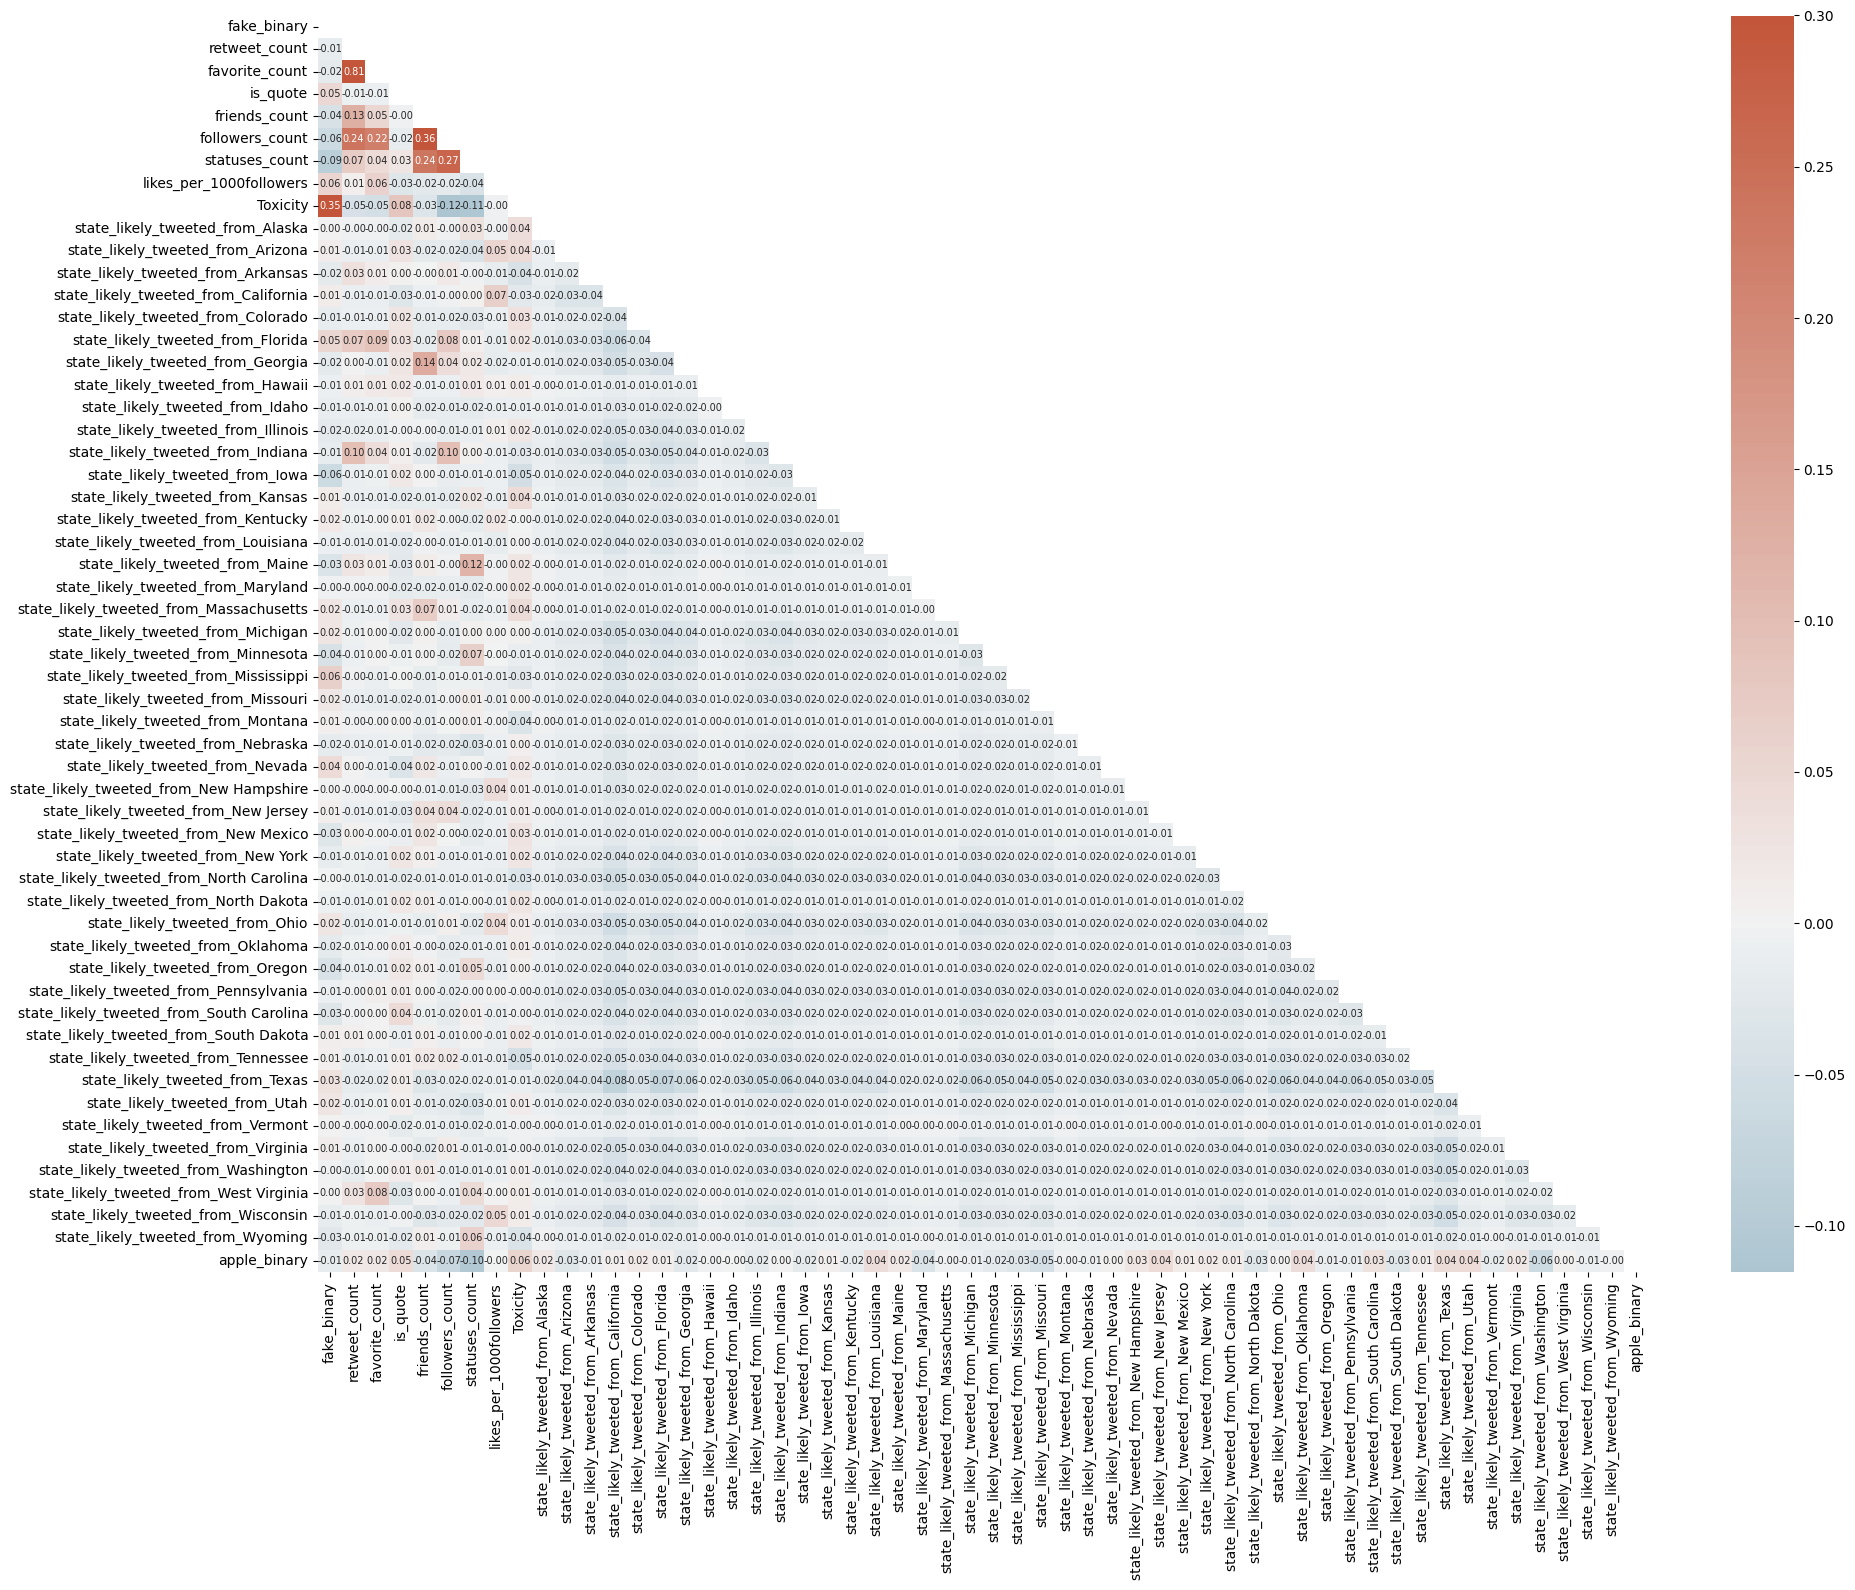

In [12]:
# Calculate the Correlation Matrix
corr = YX.corr()

# Plotting
plt.figure(figsize=(20, 16))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True, fmt=".2f", annot_kws={"size": 7})
plt.tight_layout()
plt.show()

In [13]:
# Add constant
X_const = sm.add_constant(X)

# Split data into 75% training and 25% test sets
X_train, X_test, y_train, y_test = train_test_split(X_const, y, test_size=0.25, random_state=42)

YX_train = pd.concat([y_train, X_train], axis=1)
YX_test = pd.concat([y_test, X_test], axis=1)

In [14]:
# Define predictors for each model variant
predictors = {
    'a': ['const'],
    'b': [col for col in X_const.columns if (col not in states_matrix.columns.to_list()) and (col not in ['likes_per_1000followers'])],
    'c': [col for col in X_const.columns if (col not in states_matrix.columns.to_list()) and (col not in ['followers_count', 'favorite_count'])],
    'd': X_const.drop(columns=[]).columns.tolist()
}

In [15]:
predictors

{'a': ['const'],
 'b': ['const',
  'retweet_count',
  'favorite_count',
  'is_quote',
  'friends_count',
  'followers_count',
  'statuses_count',
  'Toxicity',
  'apple_binary'],
 'c': ['const',
  'retweet_count',
  'is_quote',
  'friends_count',
  'statuses_count',
  'likes_per_1000followers',
  'Toxicity',
  'apple_binary'],
 'd': ['const',
  'retweet_count',
  'favorite_count',
  'is_quote',
  'friends_count',
  'followers_count',
  'statuses_count',
  'likes_per_1000followers',
  'Toxicity',
  'state_likely_tweeted_from_Alaska',
  'state_likely_tweeted_from_Arizona',
  'state_likely_tweeted_from_Arkansas',
  'state_likely_tweeted_from_California',
  'state_likely_tweeted_from_Colorado',
  'state_likely_tweeted_from_Florida',
  'state_likely_tweeted_from_Georgia',
  'state_likely_tweeted_from_Hawaii',
  'state_likely_tweeted_from_Idaho',
  'state_likely_tweeted_from_Illinois',
  'state_likely_tweeted_from_Indiana',
  'state_likely_tweeted_from_Iowa',
  'state_likely_tweeted_from_Kan

In [16]:
y = YX_train['fake_binary'].astype(int) # Target variable

# Define K
K = 5

# Setup the KFold cross-validation
kf = KFold(n_splits=K, shuffle=True)

# Initialize a dictionary to store Brier scores
scores = {key: [] for key in predictors}

# Initialize dictionaries to store scores
brier_scores = {key: [] for key in predictors}
acc_scores = {key: [] for key in predictors}  
balanced_acc_scores = {key: [] for key in predictors}
aic_scores = {key: [] for key in predictors}  # AIC scores

for key, cols in predictors.items():
    
    for train_index, test_index in kf.split(YX_train):
        
        # Split into train and test according to the folds 
        X_train, X_test = YX_train.iloc[train_index][cols], YX_train.iloc[test_index][cols]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # For each fold split, fit the model
        model = sm.Logit(y_train, X_train).fit(disp=0)  # disp=0 suppresses the output
                
        # Predict probabilities
        y_pred_prob = model.predict(X_test)

        # Calculate Brier score
        brier_score = brier_score_loss(y_test, y_pred_prob)
        brier_scores[key].append(brier_score)

        # Convert probabilities to binary predictions (assume simple >0.5 probability as threshold)
        y_pred_binary = (y_pred_prob > 0.5).astype(int)

        # Calculate Accuracy Score
        acc_score = accuracy_score(y_test, y_pred_binary)
        acc_scores[key].append(acc_score)
        
        # Calculate Balanced Accuracy Score
        bal_acc_score = balanced_accuracy_score(y_test, y_pred_binary)
        balanced_acc_scores[key].append(bal_acc_score)
        
        # Store AIC
        aic_scores[key].append(model.aic)
        
        print(model.summary())
        
# Calculate and print the average scores
results = []
for key in predictors.keys():
    average_brier_score = np.mean(brier_scores[key])
    print(average_brier_score)
    average_bal_acc_score = np.mean(balanced_acc_scores[key])
    average_acc_score = np.mean(acc_scores[key])
    average_aic_score = np.mean(aic_scores[key])  # Calculate average AIC
    results.append({
        'Model': key,
        'Average Brier Score': average_brier_score,
        'Average Accuracy': average_acc_score,
        'Average Balanced Accuracy': average_bal_acc_score,
        'Average AIC': average_aic_score
    })

# Convert results to DataFrame for nicer display
results_df = pd.DataFrame(results)
results_df

                           Logit Regression Results                           
Dep. Variable:            fake_binary   No. Observations:                 1200
Model:                          Logit   Df Residuals:                     1199
Method:                           MLE   Df Model:                            0
Date:                Tue, 26 Mar 2024   Pseudo R-squ.:               3.434e-12
Time:                        10:11:47   Log-Likelihood:                -701.89
converged:                       True   LL-Null:                       -701.89
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.9862      0.065    -15.196      0.000      -1.113      -0.859
                           Logit Regression Results                           
Dep. Variable:            fake_binary   No. Observat

                           Logit Regression Results                           
Dep. Variable:            fake_binary   No. Observations:                 1200
Model:                          Logit   Df Residuals:                     1191
Method:                           MLE   Df Model:                            8
Date:                Tue, 26 Mar 2024   Pseudo R-squ.:                  0.1233
Time:                        10:11:49   Log-Likelihood:                -617.04
converged:                       True   LL-Null:                       -703.86
Covariance Type:            nonrobust   LLR p-value:                 2.226e-33
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -2.9987      0.238    -12.584      0.000      -3.466      -2.532
retweet_count      -0.0113      0.049     -0.233      0.816      -0.106       0.084
favorite_count   7.665e-05      

c:\Users\jelle\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:            fake_binary   No. Observations:                 1200
Model:                          Logit   Df Residuals:                     1144
Method:                           MLE   Df Model:                           55
Date:                Tue, 26 Mar 2024   Pseudo R-squ.:                  0.1687
Time:                        10:11:53   Log-Likelihood:                -582.69
converged:                      False   LL-Null:                       -700.90
Covariance Type:            nonrobust   LLR p-value:                 2.376e-24
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -3.6254      0.498     -7.279      0.000      -4.602      -2.649
retweet_count                            

c:\Users\jelle\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:            fake_binary   No. Observations:                 1200
Model:                          Logit   Df Residuals:                     1144
Method:                           MLE   Df Model:                           55
Date:                Tue, 26 Mar 2024   Pseudo R-squ.:                  0.1749
Time:                        10:11:54   Log-Likelihood:                -587.08
converged:                      False   LL-Null:                       -711.54
Covariance Type:            nonrobust   LLR p-value:                 1.777e-26
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -2.9335      0.451     -6.507      0.000      -3.817      -2.050
retweet_count                            

c:\Users\jelle\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:            fake_binary   No. Observations:                 1200
Model:                          Logit   Df Residuals:                     1144
Method:                           MLE   Df Model:                           55
Date:                Tue, 26 Mar 2024   Pseudo R-squ.:                  0.1762
Time:                        10:11:55   Log-Likelihood:                -575.78
converged:                      False   LL-Null:                       -698.91
Covariance Type:            nonrobust   LLR p-value:                 5.034e-26
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -3.1608      0.473     -6.689      0.000      -4.087      -2.235
retweet_count                            

c:\Users\jelle\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                           Logit Regression Results                           
Dep. Variable:            fake_binary   No. Observations:                 1200
Model:                          Logit   Df Residuals:                     1144
Method:                           MLE   Df Model:                           55
Date:                Tue, 26 Mar 2024   Pseudo R-squ.:                  0.1660
Time:                        10:11:57   Log-Likelihood:                -582.92
converged:                      False   LL-Null:                       -698.91
Covariance Type:            nonrobust   LLR p-value:                 1.332e-23
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -3.5130      0.486     -7.226      0.000      -4.466      -2.560
retweet_count                            

,Model,Average Brier Score,Average Accuracy,Average Balanced Accuracy,Average AIC
0,a,0.198333,0.727333,0.500000,1408.134523
1,b,0.172677,0.744667,0.543982,1246.166737
2,c,0.171891,0.746000,0.548542,1236.411957
3,d,0.182137,0.721333,0.565832,1282.135923


In [17]:
# Now fit the model to the full validation set
model = sm.Logit(YX_train['fake_binary'], YX_train[predictors['c']]).fit()

Optimization terminated successfully.
         Current function value: 0.509408
         Iterations 7


In [18]:
# Get summary results 
summary = model.summary()
print(summary)

                           Logit Regression Results                           
Dep. Variable:            fake_binary   No. Observations:                 1500
Model:                          Logit   Df Residuals:                     1492
Method:                           MLE   Df Model:                            7
Date:                Tue, 26 Mar 2024   Pseudo R-squ.:                  0.1305
Time:                        10:11:57   Log-Likelihood:                -764.11
converged:                       True   LL-Null:                       -878.84
Covariance Type:            nonrobust   LLR p-value:                 6.476e-46
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      -3.0888      0.219    -14.122      0.000      -3.517      -2.660
retweet_count              -0.0090      0.026     -0.343      0.732      -0.060       0.042


In [19]:
# Extract the coefficients (betas) and their covariance matrix from the logistic regression fit
beta_mean = model.params
beta_cov = model.cov_params()

# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = multivariate_normal.rvs(mean=beta_mean, cov=beta_cov, size=n_simulations)

In [20]:
simulated_betas

array([[-3.06551551e+00, -8.65397432e-04,  1.89884185e-01, ...,
         1.73660908e-03,  3.67920023e-01, -8.10459366e-02],
       [-2.81767159e+00,  1.88140618e-02,  4.42144945e-02, ...,
         1.44307857e-03,  3.21213688e-01, -2.23238821e-01],
       [-3.03244765e+00,  5.13859752e-02, -2.40580607e-01, ...,
         1.40788522e-03,  3.56904580e-01, -3.38863193e-02],
       ...,
       [-3.44972814e+00, -1.63168929e-03, -1.64533286e-01, ...,
         1.04274658e-03,  4.14261319e-01, -1.66024988e-01],
       [-2.92642541e+00,  1.32390231e-02,  2.60552405e-01, ...,
         1.05670659e-03,  3.41077908e-01, -9.58757220e-02],
       [-2.86517307e+00,  6.63322568e-03, -6.24168612e-02, ...,
         1.40820644e-03,  3.25942774e-01, -1.77629705e-01]])

In [23]:
# Initialize an array to store predictions from each simulation
predictions = np.zeros((n_simulations, YX_test.shape[0]))

# Generate predictions for each simulation
for i in range(n_simulations):
    beta_simulation = simulated_betas[i]
    log_odds = np.dot(YX_test[predictors['c']], beta_simulation)
    beta_odds = np.exp(log_odds)  # Fix: Use log_odds instead of simulated_betas
    probabilities = logistic_sigmoid(log_odds)  # Convert log-odds to probabilities
    predictions[i] = probabilities

# Derive odds from log-odds coefficients 
simulated_beta_odds = np.exp(simulated_betas)


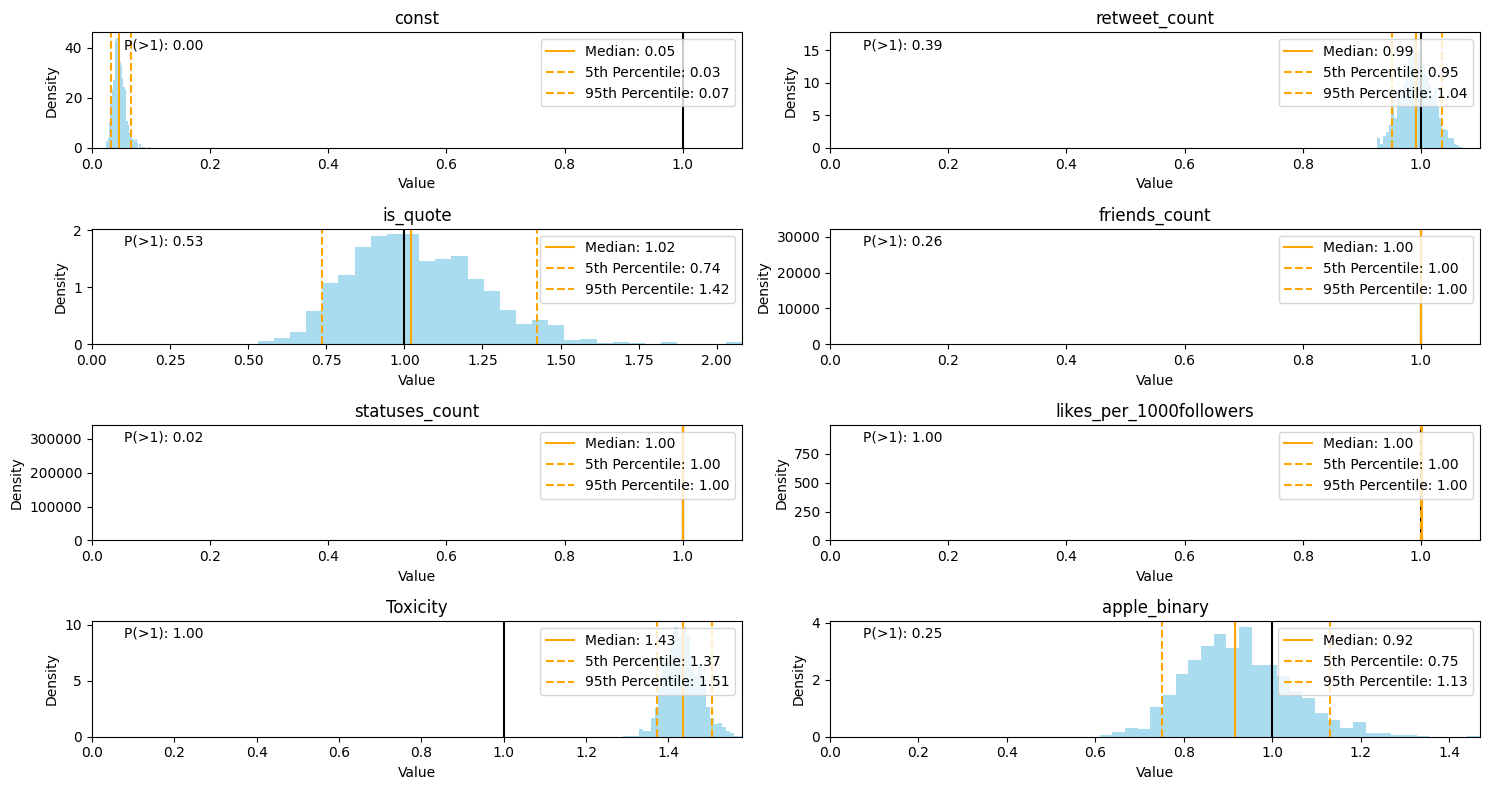

In [25]:
# Calculate statistics for each coefficient
medians = np.median(simulated_beta_odds, axis=0)
lower_quantiles = np.percentile(simulated_beta_odds, 5, axis=0)
upper_quantiles = np.percentile(simulated_beta_odds, 95, axis=0)
prob_positive = np.mean(simulated_beta_odds > 1, axis=0)

# Plot names 
col_names = predictors['c']

# Plot histograms of each coefficient
num_rows = (simulated_betas.shape[1] + 1) // 2  # Adjusted number of rows
fig, axs = plt.subplots(num_rows, 2, figsize=(15, 8))
axs = axs.flatten()

for i in range(simulated_betas.shape[1]):
    ax = axs[i]
    ax.hist(simulated_beta_odds[:, i], bins=30, density=True, alpha=0.7, color='skyblue')

    # Add vertical lines for 0
    ax.axvline(1, color='black', linestyle='-')
    
    # Add vertical lines for median and 90% interval
    ax.axvline(medians[i], color='orange', linestyle='-', label=f'Median: {medians[i]:.2f}')
    ax.axvline(lower_quantiles[i], color='orange', linestyle='--', label=f'5th Percentile: {lower_quantiles[i]:.2f}')
    ax.axvline(upper_quantiles[i], color='orange', linestyle='--', label=f'95th Percentile: {upper_quantiles[i]:.2f}')
    
    # Add text annotation for probability above 1
    ax.text(0.05, 0.95, f'P(>1): {prob_positive[i]:.2f}', transform=ax.transAxes, verticalalignment='top', fontsize=10)
    
    ax.set_title(f'{ col_names[i]}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')

    # Set x-axis limit to ensure it includes 1 and starts at 0
    ax.set_xlim(left=0, right=max(1.1,abs(simulated_beta_odds[:, i]).max())) 
    
# Hide empty subplot
if simulated_betas.shape[1] % 2 != 0:
    axs[-1].axis('off')
    
plt.tight_layout()
plt.show()


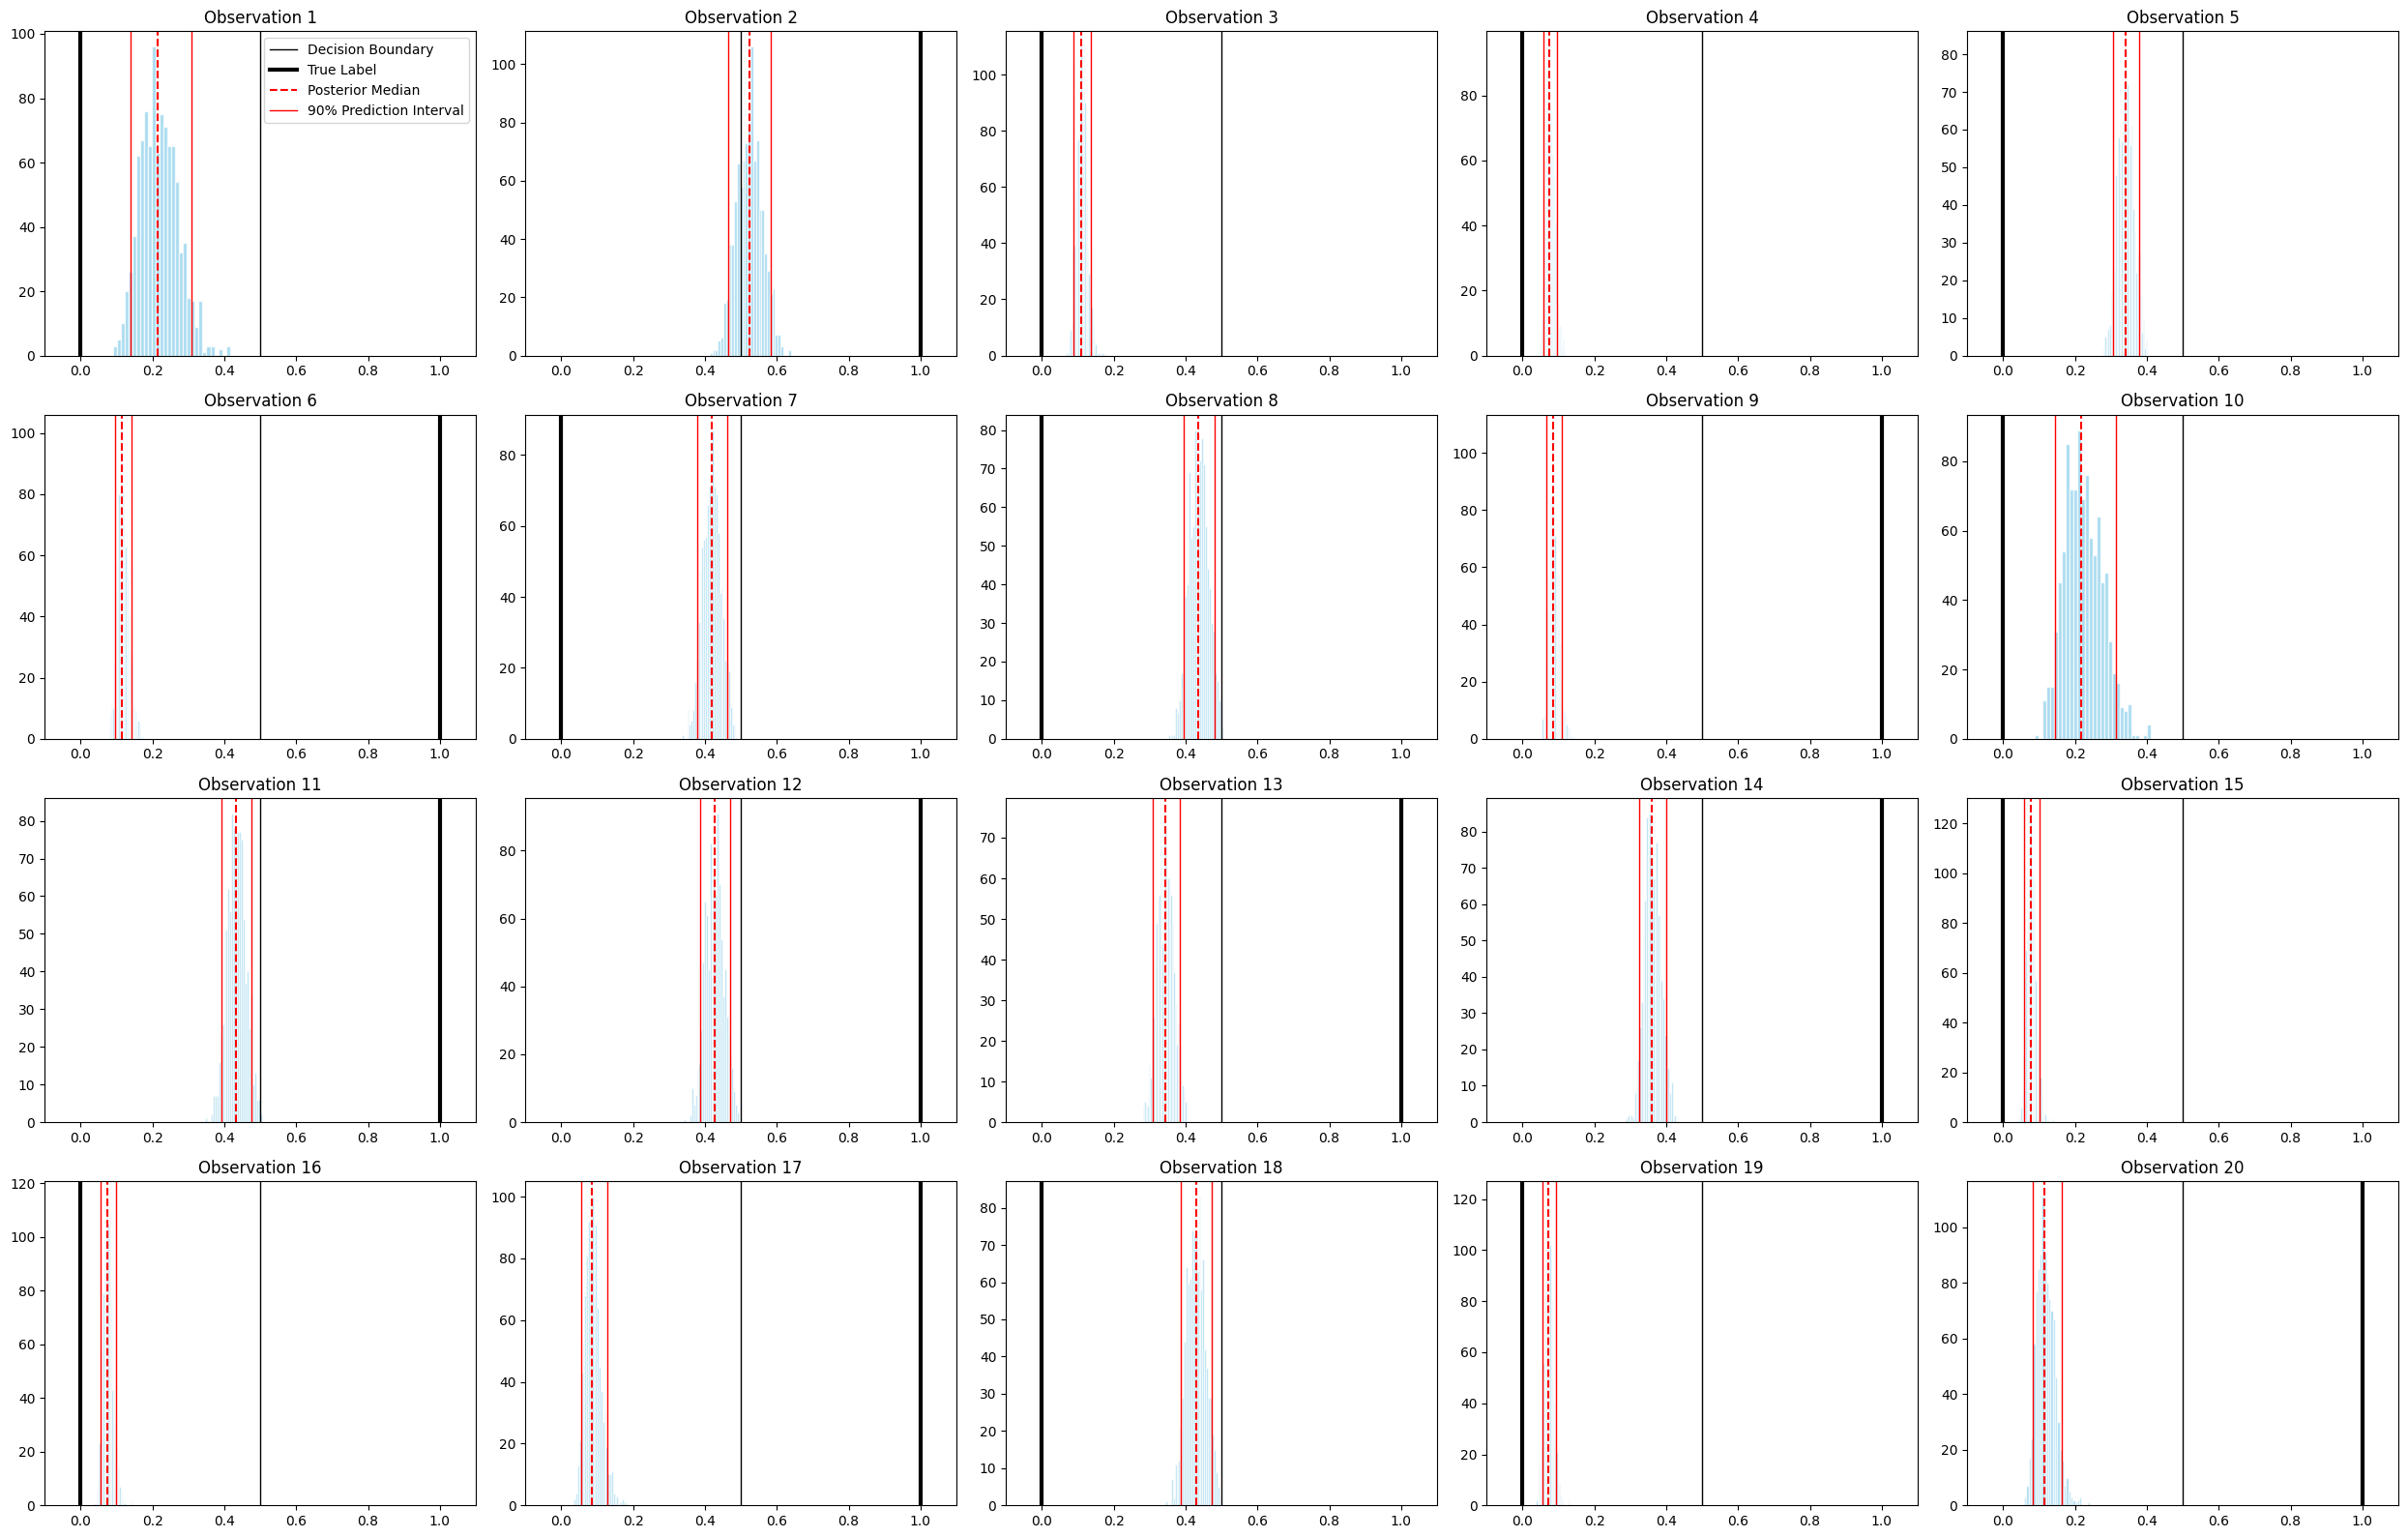

In [26]:
true_labels = YX_test['fake_binary']

# Calculate posterior median and the 90% prediction interval
posterior_medians = np.median(predictions, axis=0)
lower_bounds = np.percentile(predictions, 5, axis=0)
upper_bounds = np.percentile(predictions, 95, axis=0)

# Plotting with the adjustments for the 90% prediction interval to be shown with red lines
fig, axes = plt.subplots(4, 5, figsize=(25, 16))

for i in range(20):
    ax = axes[i // 5, i % 5]
    # Histogram of simulated probabilities for observation i
    ax.hist(predictions[:, i], bins=30, color='skyblue', edgecolor='white', alpha=0.7)
    
    # Draw a line for the decision boundary 
    ax.axvline(x=0.5, color='black', linewidth=1, label='Decision Boundary')
    
    # Draw a thick solid black line at the true label position
    true_label_position = 0 if true_labels.iloc[i] == 0 else 1  # Determine the position based on the true label
    ax.axvline(x=true_label_position, color='black', linewidth=3, label='True Label')
    
    # Add posterior median
    ax.axvline(x=posterior_medians[i], color='red', linestyle='--', label='Posterior Median')
    
    # Marking the 90% prediction interval with red lines instead of shading
    ax.axvline(x=lower_bounds[i], color='red', linestyle='-', linewidth=1, label='90% Prediction Interval' if i == 0 else "")
    ax.axvline(x=upper_bounds[i], color='red', linestyle='-', linewidth=1)
    
    ax.set_xlim(-0.1, 1.1)
    ax.set_title(f'Observation {i+1}')
    if i == 0:  # Add legend to the first subplot only to avoid repetition
        ax.legend()

plt.tight_layout()
plt.show()

In [27]:
# Simulate from the posterior-predictive distirbution 
simulated_outcomes = np.random.binomial(1, predictions)

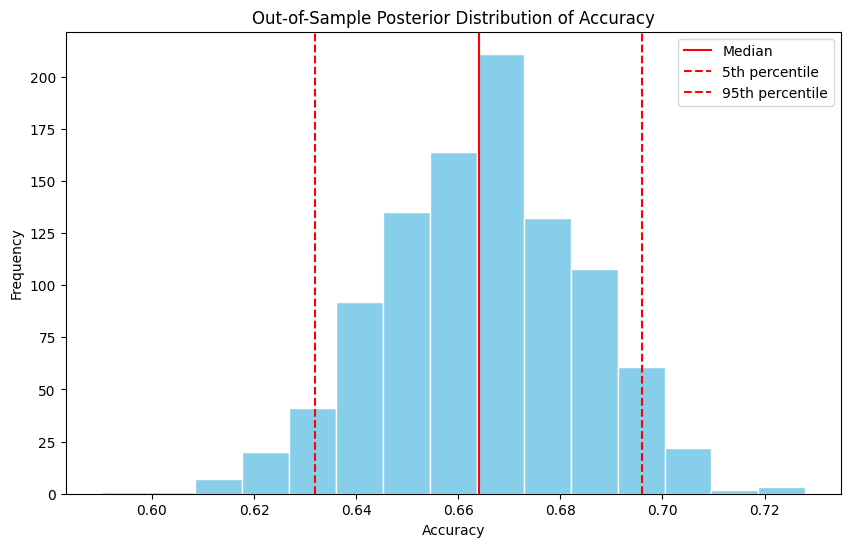

In [28]:
# Calculate accuracy for each simulation
accuracies = []
for i in range(n_simulations):
    accuracies.append(accuracy_score(true_labels, simulated_outcomes[i]))

# Plot the histogram of accuracies
plt.figure(figsize=(10, 6))
plt.hist(accuracies, bins=15, color='skyblue', edgecolor='white')
plt.axvline(x=np.median(accuracies), color='red', label='Median')
plt.axvline(x=np.percentile(accuracies, 5), color='red', linestyle='--', label='5th percentile')
plt.axvline(x=np.percentile(accuracies, 95), color='red', linestyle='--', label='95th percentile')
plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Out-of-Sample Posterior Distribution of Accuracy')
plt.legend()
plt.show()

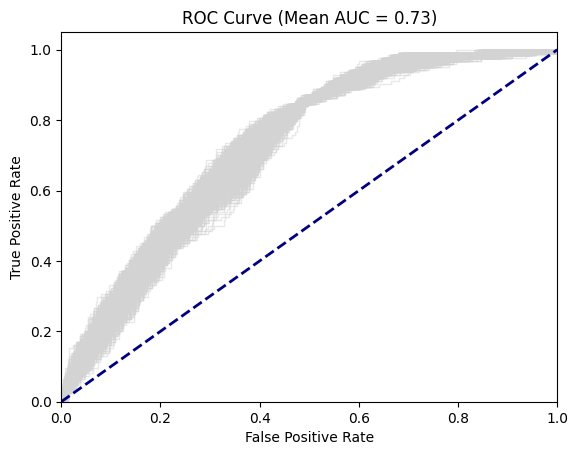

In [29]:
# Initialize lists to store TPRs (True Positive Rate), FPRs (False Positive Rare), and AUCs (Area Under the Curve) for each simulation
tprs = []
fprs = []
aucs = []

# Calculate ROC curve and AUC for each simulation
for i in range(n_simulations):
    fpr, tpr, thresholds = roc_curve(true_labels, predictions[i])
    roc_auc = auc(fpr, tpr)
    tprs.append(tpr)
    fprs.append(fpr)
    aucs.append(roc_auc)
    plt.plot(fpr, tpr, color='lightgray', lw=1, alpha=0.5)  # Plot each ROC curve faintly

# Calculate the mean AUC
mean_auc = np.mean(aucs)

# Plotting
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title(f'ROC Curve (Mean AUC = {mean_auc:.2f})')
plt.show()

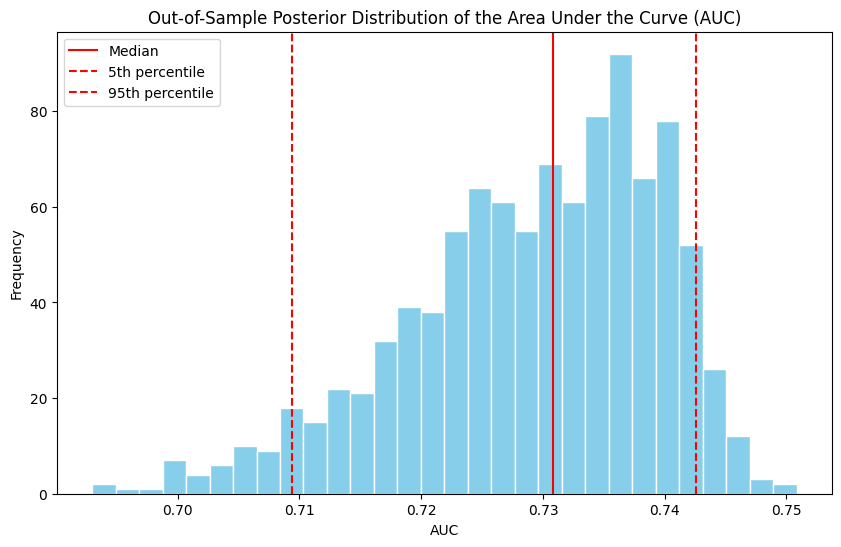

In [30]:
# Plot the histogram of AUC
plt.figure(figsize=(10, 6))
plt.hist(aucs, bins=30, color='skyblue', edgecolor='white')
plt.axvline(x=np.median(aucs), color='red', label='Median')
plt.axvline(x=np.percentile(aucs, 5), color='red', linestyle='--', label='5th percentile')
plt.axvline(x=np.percentile(aucs, 95), color='red', linestyle='--', label='95th percentile')
plt.xlabel('AUC')
plt.ylabel('Frequency')
plt.title('Out-of-Sample Posterior Distribution of the Area Under the Curve (AUC)')
plt.legend()
plt.show()

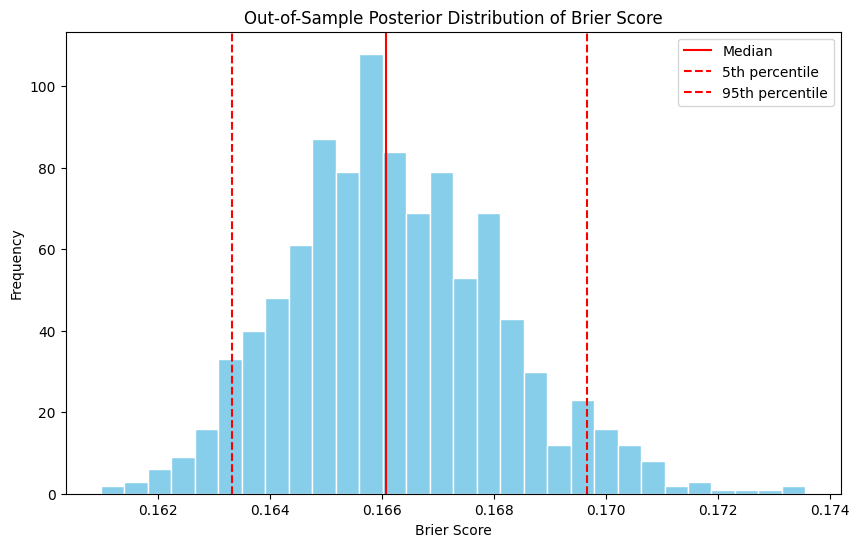

In [31]:
# Calculate Brier score for each simulation
briers = [brier_score_loss(true_labels, predictions[i]) for i in range(n_simulations)]

# Plot the histogram of Brier scores
plt.figure(figsize=(10, 6))
plt.hist(briers, bins=30, color='skyblue', edgecolor='white')
plt.axvline(x=np.median(briers), color='red', label='Median')
plt.axvline(x=np.percentile(briers, 5), color='red', linestyle='--', label='5th percentile')
plt.axvline(x=np.percentile(briers, 95), color='red', linestyle='--', label='95th percentile')
plt.xlabel('Brier Score')
plt.ylabel('Frequency')
plt.title('Out-of-Sample Posterior Distribution of Brier Score')
plt.legend()
plt.show()
